In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("advertising.csv") 
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [29]:
df.shape

(200, 4)

In [8]:
def manual_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]

print("📊 Manual Pearson Correlation with 'Sales':")
for feature in ['TV', 'Radio', 'Newspaper']:
    corr = manual_correlation(df[feature], df['Sales'])
    print(f"{feature} ↔ Sales: {corr:.4f}")


📊 Manual Pearson Correlation with 'Sales':
TV ↔ Sales: 0.9012
Radio ↔ Sales: 0.3496
Newspaper ↔ Sales: 0.1580


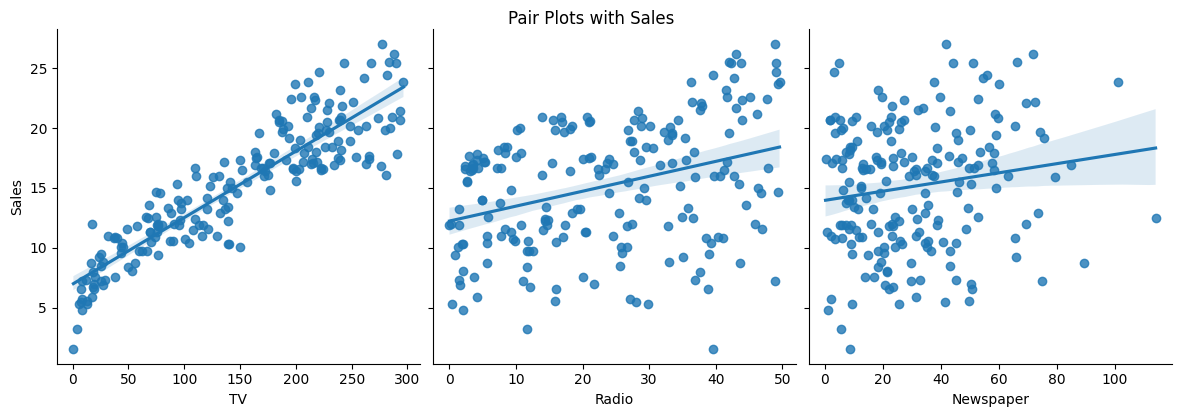

In [9]:
#pairplot
sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', kind='reg', height=4)
plt.suptitle("Pair Plots with Sales", y=1.02)
plt.show()

In [10]:

X_raw = df[['TV', 'Radio', 'Newspaper']].values
y = df['Sales'].values.reshape(-1, 1)
n_samples = X_raw.shape[0]


In [11]:

# ⚖️ Standardize features with protection against divide by zero
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_std[X_std == 0] = 1  # Avoid division by zero

X_scaled = (X_raw - X_mean) / X_std
X = np.hstack((np.ones((n_samples, 1)), X_scaled))  # Add intercept

# ⚙️ Initialize weights
w = np.zeros((X.shape[1], 1))

In [12]:
def batch_gradient_descent(X, y, alpha=0.01, epochs=1000):
    n_samples = X.shape[0]
    w = np.zeros((X.shape[1], 1))
    loss_history = []

    for epoch in range(epochs):
        y_pred = X @ w
        error = y_pred - y
        loss = (1 / (2 * n_samples)) * np.sum(error ** 2)
        loss_history.append(loss)

        gradient = (1 / n_samples) * (X.T @ error)
        w -= alpha * gradient

    return w, loss_history


In [13]:
w_batch, loss_batch = batch_gradient_descent(X, y, alpha=0.01, epochs=1000)

In [14]:
def online_gradient_descent(X, y, alpha=0.01, epochs=20):
    n_samples = X.shape[0]
    w = np.zeros((X.shape[1], 1))
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for i in range(n_samples):
            xi = X[i].reshape(1, -1)
            yi = y[i].reshape(1, 1)
            pred = xi @ w
            error = pred - yi
            grad = xi.T @ error
            w -= alpha * grad
            total_loss += (error ** 2).item()
        loss_history.append(total_loss / n_samples)

    return w, loss_history


In [15]:
w_online, loss_online = online_gradient_descent(X, y, alpha=0.01, epochs=20)

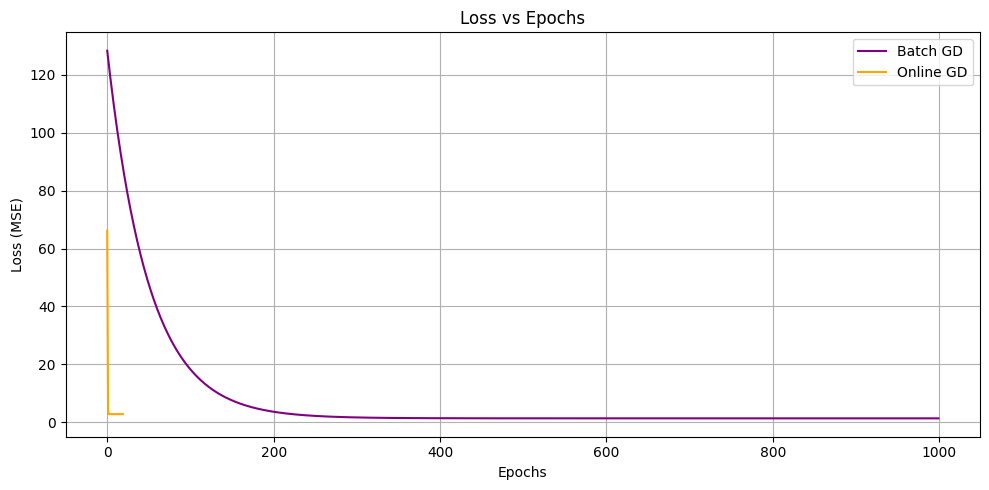

In [16]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(loss_batch)), y=loss_batch, label="Batch GD", color='purple')
sns.lineplot(x=range(len(loss_online)), y=loss_online, label="Online GD", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


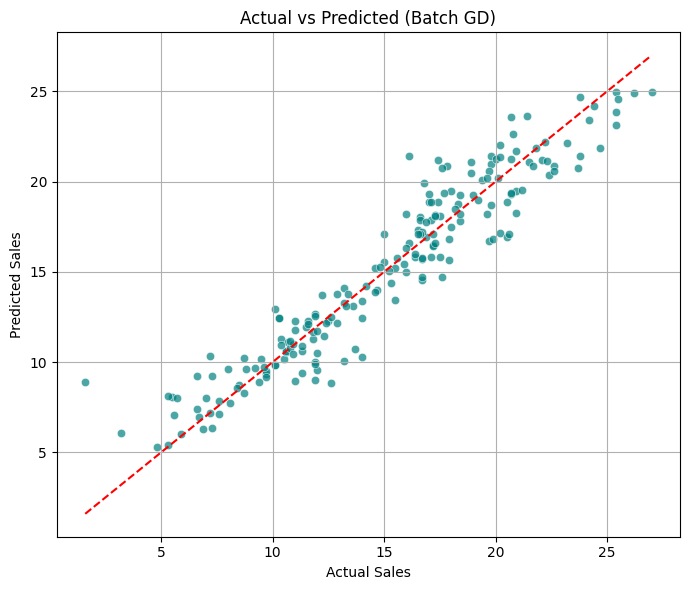

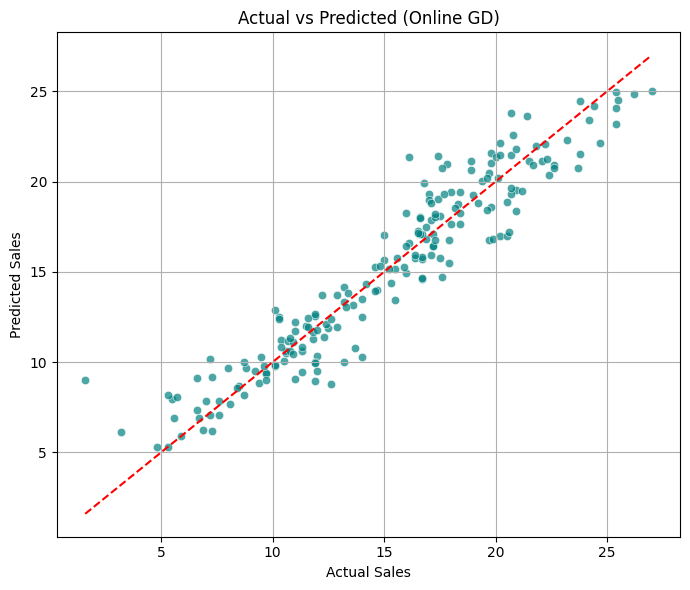

In [17]:
def plot_predictions(X, y, w, title):
    y_pred = X @ w
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y.flatten(), y=y_pred.flatten(), color='teal', alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return y_pred

y_pred_batch = plot_predictions(X, y, w_batch, "Actual vs Predicted (Batch GD)")
y_pred_online = plot_predictions(X, y, w_online, "Actual vs Predicted (Online GD)")

In [18]:
def r2_score(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_res / ss_total)

print(f"📌 R² Score (Batch GD): {r2_score(y, y_pred_batch):.4f}")
print(f"📌 R² Score (Online GD): {r2_score(y, y_pred_online):.4f}")


📌 R² Score (Batch GD): 0.9026
📌 R² Score (Online GD): 0.9022


In [19]:
    
print("\n📈 Final Parameters:")
print("Batch Gradient Descent:")
print(f"Intercept: {w_batch[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_batch[i+1][0]:.4f}")

print("\nOnline Gradient Descent:")
print(f"Intercept: {w_online[0][0]:.4f}")
for i, name in enumerate(['TV', 'Radio', 'Newspaper']):
    print(f"{name}: {w_online[i+1][0]:.4f}")



📈 Final Parameters:
Batch Gradient Descent:
Intercept: 15.1298
TV: 4.6625
Radio: 1.5835
Newspaper: 0.0086

Online Gradient Descent:
Intercept: 15.1290
TV: 4.6953
Radio: 1.6405
Newspaper: -0.0971


In [20]:
def predict_new(X_new, w, X_mean, X_std):
    
    X_new = np.array(X_new).reshape(1, -1)
    X_std_safe = np.where(X_std == 0, 1, X_std)
    X_new_scaled = (X_new - X_mean) / X_std_safe
    X_new_aug = np.hstack((np.ones((1, 1)), X_new_scaled))
    y_pred = X_new_aug @ w
    return y_pred[0][0]